# Load Packages and Data

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from kmodes.kmodes import KModes

In [67]:
portfolio = pd.read_json(r'data\01_raw\portfolio.json', lines=True)
profile = pd.read_json(r'data\01_raw\profile.json', lines=True)
transcript = pd.read_json(r'data\01_raw\transcript.json', lines=True)

# Portfolio Data

In [68]:
"""
portfolio.json
Offers sent during 30-day test period (10 offers x 6 fields)
    id (string) - offer id
    offer_type (string) - type of offer ie BOGO, discount, informational
    difficulty (int) - minimum required spend to complete an offer
    reward (int) - reward given for completing an offer
    duration (int) - time for offer to be open, in days
    channels (list of strings)
"""

# Load each JSON file into a pandas DataFrame
portfolio = pd.read_json(r'data\01_raw\portfolio.json', lines=True)
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


## Featurize the 'channels' column

In [69]:
# Convert 'channels' column into a string of space-separated strings
portfolio['channels'] = portfolio['channels'].apply(lambda x: ' '.join(x))

# Convert 'channels' column into separate binary columns
channels_profile = portfolio['channels'].str.get_dummies(' ')

# Concatenate the original DataFrame with the new 'channels' DataFrame
portfolio = pd.concat([portfolio, channels_profile], axis=1)

# Drop the original 'channels' column
portfolio = portfolio.drop('channels', axis=1)

# Rename the 'id' column to 'offer_id'
portfolio = portfolio.rename(columns={'id': 'offer_id'})

portfolio.head()

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


## Summary

In [70]:
#Count of offer_ids
num_offers = portfolio['offer_id'].nunique()

#Count of offer types
offer_types = portfolio['offer_type'].nunique()

#Create a list of offer types
offer_type_list = portfolio['offer_type'].unique()

#Convert to a offer_type_list to a string
offer_type_list = ', '.join(offer_type_list)

print("The dataset contains {} unique offers that consists of {} different offer types: {}.".
      format(num_offers, offer_types, offer_type_list))

print("The offers were sent through email, mobile, social and web channels.")

#Min and Max difficulty
min_difficulty = portfolio['difficulty'].min()
max_difficulty = portfolio['difficulty'].max()

#Min and Max reward
min_reward = portfolio['reward'].min()
max_reward = portfolio['reward'].max()

print("Customers were prompted to spend from {} to {} dollars with the rewards ranging from {} to {} dollars"
      .format(min_difficulty, max_difficulty, min_reward, max_reward))

The dataset contains 10 unique offers that consists of 3 different offer types: bogo, informational, discount.
The offers were sent through email, mobile, social and web channels.
Customers were prompted to spend from 0 to 20 dollars with the rewards ranging from 0 to 10 dollars


## Featurize offer_types

In [71]:
# Convert the offer_type column into separate binary columns
offer_type_profile = pd.get_dummies(portfolio['offer_type'], prefix='offer_type')

# Convert True/False values to 1/0
offer_type_profile = offer_type_profile.astype(int)

# Concatenate the original DataFrame with the new 'offer_type' DataFrame
portfolio = pd.concat([portfolio, offer_type_profile], axis=1)

# Drop the original 'offer_type' column
portfolio = portfolio.drop('offer_type', axis=1)

#Make the offer_id the first column in the dataframe
cols = ['offer_id'] + [col for col in portfolio if col != 'offer_id']
portfolio = portfolio[cols]

portfolio.head()

,offer_id,reward,difficulty,duration,email,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational
0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,1,1,0,1,0,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,1,1,1,1,1,0,0
2,3f207df678b143eea3cee63160fa8bed,0,0,4,1,1,0,1,0,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,1,1,0,1,1,0,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,1,0,0,1,0,1,0


## Graph offer_types and channels

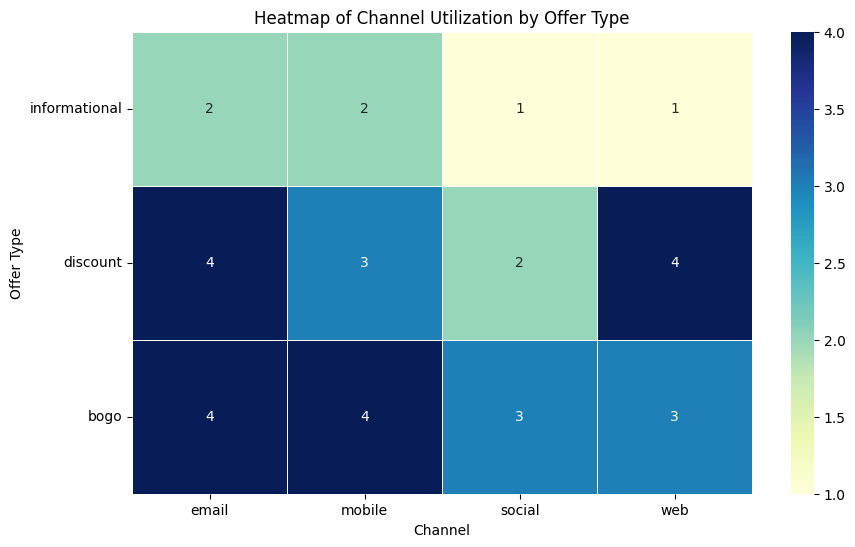

In [72]:
# Create a new DataFrame to summarize the channel utilization by offer type
channel_utilization = portfolio[['offer_type_bogo', 'offer_type_discount', 'offer_type_informational', 'email', 'mobile', 'social', 'web']]

# Group by offer type and sum the channels
channel_utilization_summary = channel_utilization.groupby(['offer_type_bogo', 'offer_type_discount', 'offer_type_informational']).sum()

# Reset index to make the DataFrame easier to handle
channel_utilization_summary.reset_index(inplace=True)

# Map offer type columns to a single 'offer_type' column for easier plotting
channel_utilization_summary['offer_type'] = channel_utilization_summary.apply(
    lambda row: 'bogo' if row['offer_type_bogo'] == 1 else ('discount' if row['offer_type_discount'] == 1 else 'informational'), axis=1)

# Drop the offer type indicator columns
channel_utilization_summary.drop(columns=['offer_type_bogo', 'offer_type_discount', 'offer_type_informational'], inplace=True)

# Set 'offer_type' as the index
channel_utilization_summary.set_index('offer_type', inplace=True)

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(channel_utilization_summary, annot=True, cmap='YlGnBu', fmt='d', linewidths=.5)

plt.title('Heatmap of Channel Utilization by Offer Type')
plt.xlabel('Channel')
plt.ylabel('Offer Type')

# Rotate y-axis labels
plt.yticks(rotation=0)

plt.show()

## Export Featurized Data

In [73]:
#Export the cleaned data to .csv
portfolio.to_csv(r'data\02_stg\stg_portfolio.csv', index=False)

#Pickle the cleaned data
portfolio.to_pickle(r'data\02_stg\stg_portfolio.pkl')

# Profile Data

In [74]:
"""
profile.json
Rewards program users (17000 users x 5 fields)
Details the different offers sent during the test period, including offer type (buy-one-get-one, discount, informational), reward amount, required spending threshold, duration, and delivery channels.
    age (int) - age of the customer (missing value is encoded as 118)
    became_member_on (int) - date when customer created an app account
    gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
    id (str) - customer id
    income (float) - customer's income

"""
# Rename the 'id' column to 'customer_id'
profile = profile.rename(columns={'id': 'customer_id'})

#Convert 'became_member_on' to datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

profile.head()

,gender,age,customer_id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


## Standardize Null Values

In [75]:
# Replace None with NaN
profile['gender'] = profile['gender'].fillna(np.nan)

# Replace 118 with NaN
profile['age'] = profile['age'].replace(118, np.nan)

profile.head()

,gender,age,customer_id,became_member_on,income
0,NaN,NaN,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,NaN,NaN,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,NaN,NaN,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


## Summary

### Data Density

In [76]:
# Percentage of missing values in each column
nan_percent = round(profile.isna().mean() * 100, 2)
print(nan_percent)

gender              12.79
age                 12.79
customer_id          0.00
became_member_on     0.00
income              12.79
dtype: float64


### Data Distribution

In [77]:
# Calculate membership duration in days from the max date in the dataset
profile['days_as_member'] = (profile['became_member_on'].max()- profile['became_member_on']).dt.days

# Save cleaned data to .csv
profile.to_csv(r'data\02_stg\stg_profile.csv', index=False)

# For profile[['days_as_member', 'age', 'income']], call the describe method and then transpose the results
profile_statistics = profile[['days_as_member', 'age', 'income']].describe().astype(int)

#Add a row that calculates the range for each column
profile_range = (profile[['days_as_member', 'age', 'income']].max() - profile[['days_as_member', 'age', 'income']].min()).astype(int)
profile_range = profile_range.to_frame().T
profile_range.index = ['range']

#Concatenate the two DataFrames
profile_statistics = pd.concat([profile_statistics, profile_range]).T

#Save cleaned data to .csv
profile_statistics.to_csv(r'data\04_fct\fct_profile_statistics.csv', index=False)

profile_statistics.head()

,count,mean,std,min,25%,50%,75%,max,range
days_as_member,17000,517,411,0,208,358,791,1823,1823
age,14825,54,17,18,42,55,66,101,83
income,14825,65404,21598,30000,49000,64000,80000,120000,90000


In [78]:
# Calculate value counts
gender_counts = profile['gender'].value_counts(dropna=False).to_frame().reset_index()
gender_counts.columns = ['Gender', 'Count']

# Calculate percentages
gender_percentages = profile['gender'].value_counts(normalize=True, dropna=False).mul(100).round(2).to_frame().reset_index()
gender_percentages.columns = ['Gender', 'Percentage']

# Merge the two DataFrames
gender_stats = pd.merge(gender_counts, gender_percentages, on='Gender')
gender_stats

,Gender,Count,Percentage
0,M,8484,49.91
1,F,6129,36.05
2,NaN,2175,12.79
3,O,212,1.25


## Segmenting Customers

In [79]:
#Create age categories
bins = [18, 25, 35, 45, 55, 65, 75, 102]
labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75+']
profile['age_group'] = pd.cut(profile['age'], bins=bins, labels=labels, right=False)
profile = profile.drop('age', axis=1)

#Create income categories
bins = [30000, 50000, 75000, 100000, 120001]
labels = ['<50K', '50K-74K', '75K-99K', '100K+']
profile['income_group'] = pd.cut(profile['income'], bins=bins, labels=labels, right=False)
profile = profile.drop('income', axis=1)

#Create days as member quartiles
profile['membership_days_group'] = pd.qcut(profile['days_as_member'], q=4, labels=['1st Quartile', '2nd Quartile', '3rd Quartile', '4th Quartile'])
profile = profile.drop(['days_as_member','became_member_on'], axis=1)

#make customer id the first column
cols = ['customer_id'] + [col for col in profile if col != 'customer_id']
profile = profile[cols]

#Split the data set into two dataframes. One with missing values and one without
cat_profile_missing = profile[profile.isnull().any(axis=1)]
cat_profile_missing = cat_profile_missing.reset_index(drop=True)

cat_profile_clean = profile.dropna()
cat_profile_clean = cat_profile_clean.reset_index(drop=True)
cat_profile_clean.head()

,customer_id,gender,age_group,income_group,membership_days_group
0,0610b486422d4921ae7d2bf64640c50b,F,55-64,100K+,3rd Quartile
1,78afa995795e4d85b5d9ceeca43f5fef,F,75+,100K+,3rd Quartile
2,e2127556f4f64592b11af22de27a7932,M,65-74,50K-74K,1st Quartile
3,389bc3fa690240e798340f5a15918d5c,M,65-74,50K-74K,1st Quartile
4,2eeac8d8feae4a8cad5a6af0499a211d,M,55-64,50K-74K,2nd Quartile


Below, I'm using the K-Modes clustering algorithm, an unsupervised learning technique, to segment the categorized customer data.

Optimal amount of clusters according to the elbow method:  2


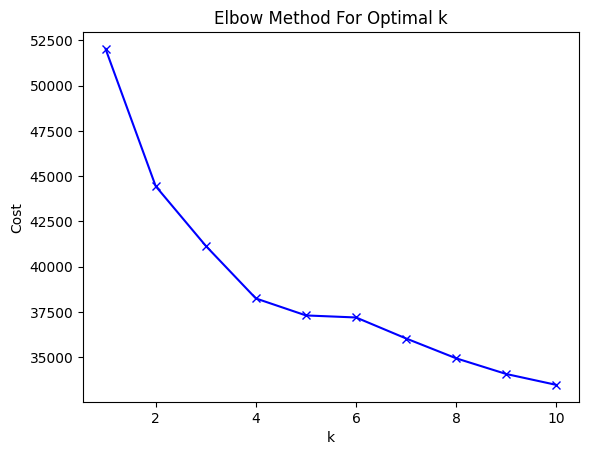

In [80]:
def optimal_num_clusters(data, max_clusters):
    costs = []
    for num_clusters in range(1, max_clusters+1):
        np.random.seed(42)  # Set the seed here
        km = KModes(n_clusters=num_clusters, init='Huang', n_init=5, verbose=0)
        km.fit_predict(data)
        costs.append(km.cost_)

    # Calculate the difference in costs
    diff_costs = np.diff(costs)

    # Find the elbow point
    optimal_clusters = np.argmin(diff_costs) + 2  # +2 because the index starts at 0 and we started num_clusters at 1

    return optimal_clusters, costs  # Return costs as well

# Use the function to find the optimal number of clusters
optimal_clusters, costs = optimal_num_clusters(cat_profile_clean, 10)
print("Optimal amount of clusters according to the elbow method: ", optimal_clusters)

plt.plot(range(1,11), costs, 'bx-')  # Plot costs
plt.xlabel('k')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [81]:
# Create a DataFrame
kmodes_cost = pd.DataFrame({
    'k': range(1, 11),
    'cost': costs
})

# Calculate the percent change in cost
kmodes_cost['percent_change'] = kmodes_cost['cost'].pct_change() * 100

# Print the DataFrame
kmodes_cost.head()

,k,cost,percent_change
0,1,52023.0,NaN
1,2,44445.0,-14.566634
2,3,41150.0,-7.413657
3,4,38245.0,-7.059538
4,5,37307.0,-2.452608


In [82]:
# Assuming cat_profile_clean is your DataFrame and customer_id is the index
cat_profile_clean.set_index('customer_id', inplace=True)

# Perform KModes clustering
km = KModes(n_clusters=optimal_clusters, init='Huang', n_init=5, verbose=0)  # Change the number of clusters as needed
clusters = km.fit_predict(cat_profile_clean)

# Add the cluster labels to your original DataFrame
cat_profile_clean['cluster'] = clusters

In [83]:
cat_profile_clean.head()

,gender,age_group,income_group,membership_days_group,cluster
customer_id,,,,,
0610b486422d4921ae7d2bf64640c50b,F,55-64,100K+,3rd Quartile,0
78afa995795e4d85b5d9ceeca43f5fef,F,75+,100K+,3rd Quartile,0
e2127556f4f64592b11af22de27a7932,M,65-74,50K-74K,1st Quartile,1
389bc3fa690240e798340f5a15918d5c,M,65-74,50K-74K,1st Quartile,1
2eeac8d8feae4a8cad5a6af0499a211d,M,55-64,50K-74K,2nd Quartile,0


# Transcript Data

In [84]:
"""
Event log (306648 events x 4 fields)
Logs all events related to offers and transactions, such as offer receipt, offer view, transaction amount, and offer completion, along with timestamps
    event (str) - record description (ie transaction, offer received, offer viewed, etc.)
    person (str) - customer id
    time (int) - time in hours since start of test. The data begins at time t=0
    value - (dict of strings) - either an offer id or transaction amount depending on the record

"""
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
